<a href="https://colab.research.google.com/github/phmorris610/cs39aa_project/blob/main/project_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyLDAvis
!pip install textstat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import sklearn
import gensim
import pyLDAvis
import wordcloud
import textblob
import spacy
import textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2060f3e5ff7702936b2b7a17c930ca61ee8d89bda7bcb12de3ab72cccb2b5536
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=d2c6d1d08b4fa0c1175582c32446bf7634ac4f9ac0c014b1eac51cf1d7f0fcc8
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [11]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv('rtom2.csv')

tomatoes = data.dropna()
tomatoes.reset_index(inplace=True)
print(tomatoes.shape)
print(tomatoes.head())




Saving rtom2.csv to rtom2 (1).csv
(9508, 9)
   index rotten_tomatoes_link  top_critic  Top_Critic  \
0      0            m/0814255       False           0   
1      1            m/0814255       False           0   
2      2            m/0814255       False           0   
3      3            m/0814255        True           1   
4      4            m/0814255        True           1   

            publisher_name review_type  Review_Type review_date  \
0           Urban Cinefile       Fresh            1    2/6/2010   
1      FILMINK (Australia)       Fresh            1    2/9/2010   
2  Sunday Mail (Australia)       Fresh            1    2/9/2010   
3       Hollywood Reporter      Rotten            0   2/10/2010   
4         Associated Press      Rotten            0   2/10/2010   

                                      review_content  
0  Uma Thurman as Medusa, the gorgon with a coiff...  
1  With a top-notch cast and dazzling special eff...  
2  Whether audiences will get behind The Ligh

In [13]:
selections1 = ['Review_Type', 'review_content']
selections2 = ['Top_Critic', 'review_content']
X = tomatoes[selections1].copy()
X2 = tomatoes[selections2].copy()
y = tomatoes.pop('Review_Type')
y2 = tomatoes.pop('Top_Critic')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

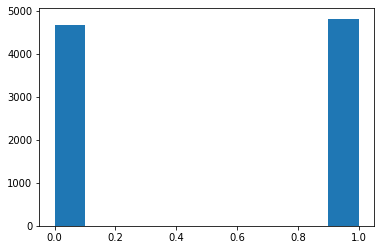

In [15]:
import matplotlib.pyplot as plt
plt.hist(y)
plt

In [16]:
import numpy as np
y_num = np.asarray(y)
unique, counts = np.unique(y_num, return_counts=True)
print(f"Count of 0 = Rotten and 1 = Fresh: {dict(zip(unique, counts))}") 

Count of 0 = Rotten and 1 = Fresh: {0: 4684, 1: 4824}


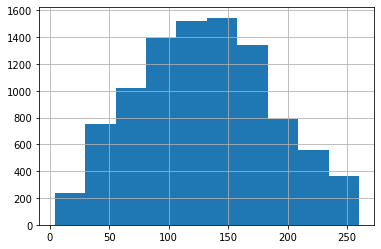

In [17]:
X['review_content'].str.len().hist()

This shows the average length of a review is ~130 characters

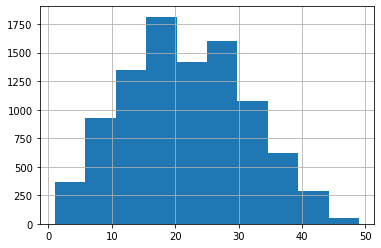

In [19]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()
plot_word_number_histogram(X['review_content'])

This shows the average number of words per review to be ~20

#Below we will tokenize and remove characters and stopwords.

In [20]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop = set(stopwords.words('english'))
corpus = []
new = X['review_content'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
from collections import defaultdict

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

In [22]:
from nltk.tokenize import TreebankWordTokenizer

twt = TreebankWordTokenizer()
X['tokens_raw'] = X['review_content'].apply(lambda x: twt.tokenize(x.lower()))
chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
X['tokens_raw'] = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
pd.set_option("display.max_colwidth", 300)
X_tRaw = X['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove and w not in stop])
Xtclean = X_tRaw.apply(lambda x: ' '.join(x))
X_tRaw.head()

0                                                [uma, thurman, medusa, gorgon, coiffure, writhing, snakes, stone-inducing, hypnotic, gaze, one, highlights, bewitching, fantasy]
1                                                                                     [top-notch, cast, dazzling, special, effects, tide, teens, next, harry, potter, instalment]
2    [whether, audiences, get, behind, lightning, thief, hard, predict., overall, entertaining, introduction, promising, new, world, consuming, shadow, potter, big, break, free]
3                                                                             [really, lacking, lightning, thief, genuine, sense, wonder, thing, brings, viewers, back, hogwarts]
4                                                                                                                  [list, ingredients, movie-magic, potion, enjoy, start, finish]
Name: tokens_raw, dtype: object

In [24]:
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    chars2remove = set(
    ['.', '!', '/', '?', ',', '@', '#', '$', '%', '^', '&', '*', '_', '-', '~', 'The', 'A', '`', '+', "'", '"', '--',
     '[', ']',
     "'s", "n't"])
    #X_train['tokens_raw'] = X_train['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:80]:
        if (word not in stop and word != 'The' and word != 'A' and word != chars2remove):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

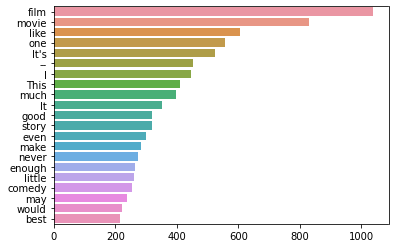

In [26]:
plot_top_non_stopwords_barchart(X['review_content'])

Here is a list of the most popular non-stopwords, film and movie the heavy hitters.

In [30]:
XFresh = X[  X['Review_Type'] == 1 ]
Xrottn = X[  X['Review_Type'] == 0 ]
XTop   = X2[  X2['Top_Critic'] == 1 ]
XNTop  = X2[  X2['Top_Critic'] == 0 ]

Now lets split the data into Fresh and Rotten reviews, and also take a look at the Top Critic or not Top Critic column's bywords.

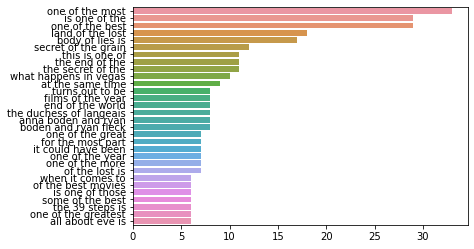

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:30]

    top_n_bigrams=_get_top_ngram(text,n)[:30]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(XFresh['review_content'],4)

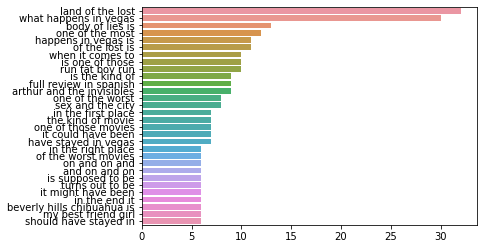

In [34]:
plot_top_ngrams_barchart(Xrottn['review_content'],4)

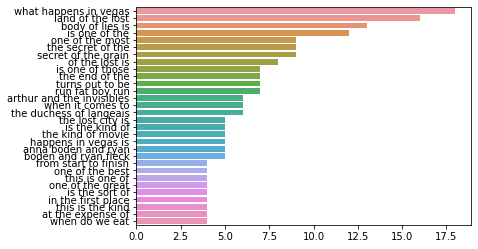

In [35]:
plot_top_ngrams_barchart(XTop['review_content'],4)

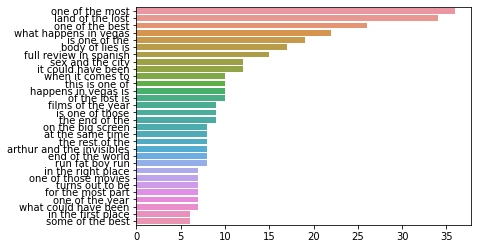

In [36]:
plot_top_ngrams_barchart(XNTop['review_content'],4)

The results are very odd, "body of lies", "land of the lost", this leads me to believe that this dataset is very biased towards a certian few movies, this will need to be investivated further. 

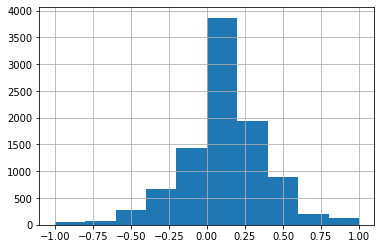

In [44]:
from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

plot_polarity_histogram(X['review_content'])

As can be seen from the above polarity plot, these reviews are slightly polarizing.

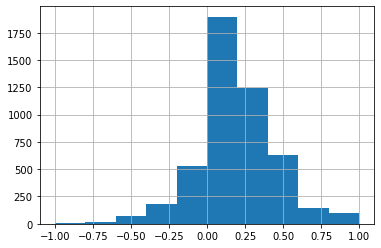

In [45]:
plot_polarity_histogram(XFresh['review_content'])

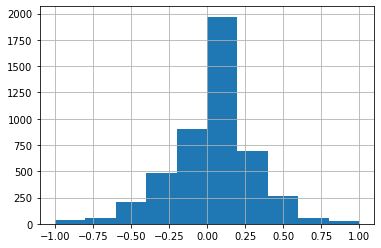

In [46]:
plot_polarity_histogram(Xrottn['review_content'])

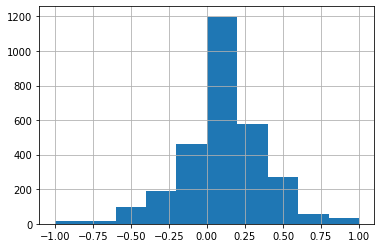

In [47]:
plot_polarity_histogram(XTop['review_content'])

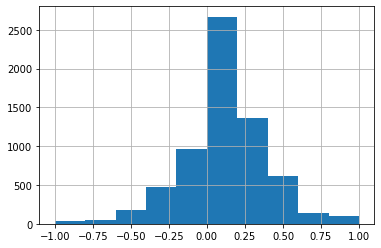

In [48]:
plot_polarity_histogram(XNTop['review_content'])

Interestingly enough the Fresh reviews are showing as more polarizing than the Rotten reviews, while Top Critic or its complement are not registering a difference.

Now lets create a onehot encoding and put it through a quick and dirty model; lets use a Random Forest.

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_hot = tfidf_vect.fit_transform(Xtclean).toarray()

print(X_hot[:3, :5])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [50]:
import torch
X_tense = torch.tensor(X_hot).float()
print(Xtclean.head())
print(X.shape)

0                                          uma thurman medusa gorgon coiffure writhing snakes stone-inducing hypnotic gaze one highlights bewitching fantasy
1                                                                            top-notch cast dazzling special effects tide teens next harry potter instalment
2    whether audiences get behind lightning thief hard predict. overall entertaining introduction promising new world consuming shadow potter big break free
3                                                                     really lacking lightning thief genuine sense wonder thing brings viewers back hogwarts
4                                                                                                     list ingredients movie-magic potion enjoy start finish
Name: tokens_raw, dtype: object
(9508, 3)


Above is the One-hot encoded Tensor 
Below we will split the data.


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_tense, y, train_size=0.80, random_state=1)

After Splitting the date I will run it through the Random Forest portion of a Classification class I wrote that has some different models for different uses.

In [56]:
class Classification:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def extraTree(self, n):
        from sklearn.ensemble import ExtraTreesClassifier
        import matplotlib.pyplot as plt
        model = ExtraTreesClassifier()
        model.fit(self.X, self.y)
        feat_importances = pd.Series(model.feature_importances_, index=self.X.columns)
        feat_importances.nlargest(n).plot(kind='barh')
        plt.show()
        feat = []
        feat.append(feat_importances.nlargest(n))
        return feat

    def normal(self, feature):
        import matplotlib.pyplot as plt
        plt.hist(self.X[feature], bins=20, edgecolor='black')
        plt.show()

    def reg(self):
        from sklearn.linear_model import LinearRegression
        import matplotlib.pyplot as plt
        linreg_model = LinearRegression()
        linreg_model.fit(self.X, self.y)
        import statsmodels.api as sm
        regModel = sm.OLS(self.y, self.X).fit()
        y_pred = linreg_model.predict(self.X)
        # and a residual plot
        plt.title('Residulas')
        plt.scatter(regModel.model.exog[:, 1], regModel.resid)
        plt.show()
        mse_linreg = ((y_pred ** 2).mean())
        print("MSE = ", mse_linreg)
        print("rMSE = ", np.sqrt(mse_linreg))
        return regModel.summary()  # finally return a Regression Summary

class DecisionTree(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def decision(self, n, feat):
        from sklearn.tree import DecisionTreeClassifier
        from sklearn import tree
        import matplotlib.pyplot as plt
        clf = tree.DecisionTreeClassifier(max_depth=n)  # set hyperparameter
        clf.fit(self.X, self.y)
        plt.figure(figsize=(12, 12))  # set plot size (denoted in inches)
        tree.plot_tree(clf, feature_names=feat, class_names=True, filled=True, fontsize=10)
        plt.show()

class RandomForest(Classification):
    def __init__(self, X, y):
        super().__init__(X, y)

    def rForestClass(self, n):
        from sklearn.ensemble import RandomForestClassifier
        import matplotlib.pyplot as plt
        from sklearn import metrics
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(self.X, self.y)
        y_pred = clf.predict(self.X)
        display = ConfusionMatrixDisplay(confusion_matrix(self.y, y_pred), display_labels=['Fresh', 'Rotten'])
        display.plot()
        plt.show()
        print("Accuracy: ", metrics.accuracy_score(self.y, y_pred) * 100, "%")

    def rForestReg(self, n, state):
        from sklearn.ensemble import RandomForestRegressor
        from sklearn import metrics
        regr = RandomForestRegressor(max_depth=n, random_state=state)
        regr.fit(self.X, self.y)
        y_pred = regr.predict(self.X)
        print("Accuracy: ", metrics.accuracy_score(self.y, y_pred))

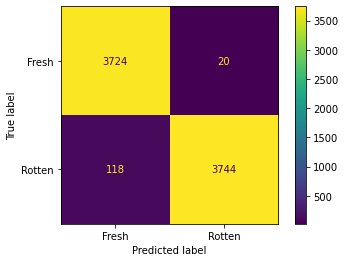

Accuracy:  98.18564291348935 %


In [62]:
rf = RandomForest(X_train, y_train)
rf.rForestClass(10)

Wow, 98 percent accuracy, the hyperparameter we used was 10 estimators, but this was the training data, lets see how it performs of the validation data.

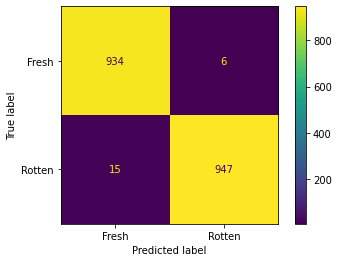

Accuracy:  98.89589905362776 %


In [64]:
rf = RandomForest(X_val, y_val)
rf.rForestClass(10)

It actually performed better on the validation data... I think my analysis so far has led me to conclude I need to really take a closer look at this data to see what is going on; why am I getting such spectacular results?

Let's try a few other estimators, possibly we got lucky and found the perfect on by chance.

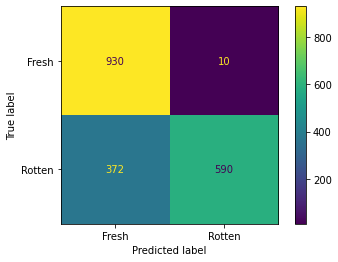

Accuracy:  79.91587802313354 %


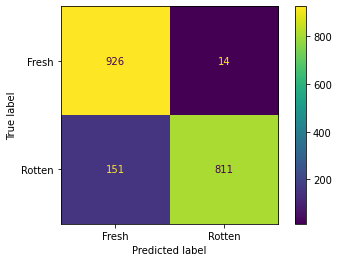

Accuracy:  91.32492113564669 %


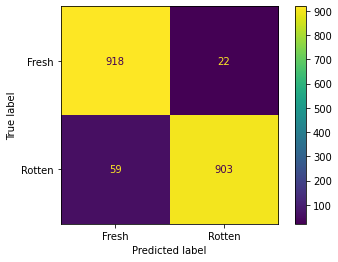

Accuracy:  95.74132492113566 %


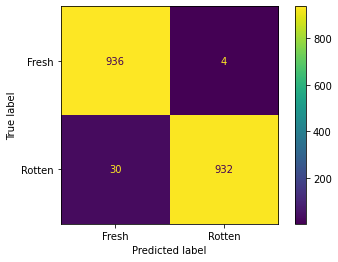

Accuracy:  98.2124079915878 %


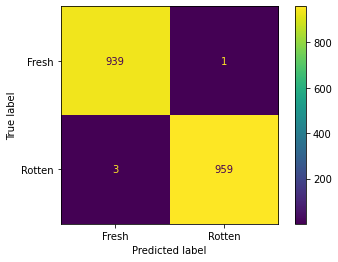

Accuracy:  99.78969505783385 %


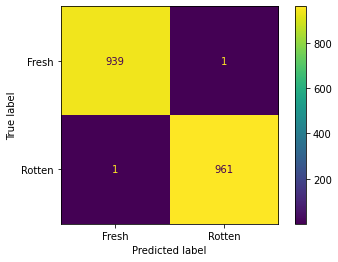

Accuracy:  99.89484752891693 %


In [65]:
rf.rForestClass(2)
rf.rForestClass(4)
rf.rForestClass(6)
rf.rForestClass(10)
rf.rForestClass(20)
rf.rForestClass(40)

Well it looks like the higher the estimator the better the accuracy. As of now after performing a cursory analysis and running the data through a quick model, my conclusion is I will need to really dig into this dataset to check its fidelity. 